# Prediction of Obesity Levels

# 1. Data Cleaning & Univariate Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
from scipy import stats
import seaborn as sns
from scipy.stats import ttest_ind
from dython.nominal import conditional_entropy
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from tabulate import tabulate

In [2]:
original_df=pd.read_csv('ObesityDataSet.csv', usecols=['Gender', 'Age', 'Height', 'Weight', \
    'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', \
    'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad'])
df=original_df.copy()
#replace index names
df=df.rename(index=str, columns={'family_history_with_overweight':'fam_hist', \
    'FAVC':'high_cal_foods', 'FCVC':'veg', 'NCP':'num_main_meals', \
    'CAEC':'food_between_meals', 'CH2O':'daily_water', 'CALC':'alcohol', \
    'SCC':'cal_consumption_monitoring', 'FAF':'physical_activity', \
    'TUE':'time_using_tech_devices', 'MTRANS':'transportation', \
    'SMOKE':'nicotine', 'NObeyesdad':'obesity_lvl'})

df=df.drop(df.index[498:])

In [3]:
#calculate mass body index from weight and height
df['BMI']=np.round(df.Weight/(df.Height*df.Height), 3)

In [4]:
df.shape

(498, 18)

In [5]:
#check columns
df.head()

,Gender,Age,Height,Weight,fam_hist,high_cal_foods,veg,num_main_meals,food_between_meals,nicotine,daily_water,cal_consumption_monitoring,physical_activity,time_using_tech_devices,alcohol,transportation,obesity_lvl,BMI
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,24.387
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,24.238
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,23.765
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,26.852
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,28.342


The last 77% of rows contain synthetic data created via the Weka tool and SMOTE filter so they were dropped. The index names were changed to be identified more easily and BMI was calculated.

## a) Missing Values & Data Types

In [6]:
#Check for missing values
df.isna().any()

Gender                        False
Age                           False
Height                        False
Weight                        False
fam_hist                      False
high_cal_foods                False
veg                           False
num_main_meals                False
food_between_meals            False
nicotine                      False
daily_water                   False
cal_consumption_monitoring    False
physical_activity             False
time_using_tech_devices       False
alcohol                       False
transportation                False
obesity_lvl                   False
BMI                           False
dtype: bool

In [7]:
#check all data types
df.dtypes

Gender                         object
Age                           float64
Height                        float64
Weight                        float64
fam_hist                       object
high_cal_foods                 object
veg                           float64
num_main_meals                float64
food_between_meals             object
nicotine                       object
daily_water                   float64
cal_consumption_monitoring     object
physical_activity             float64
time_using_tech_devices       float64
alcohol                        object
transportation                 object
obesity_lvl                    object
BMI                           float64
dtype: object

## b) Metric Variables

**Age**, **height**, **weight**, and **BMI** are metric variables. 


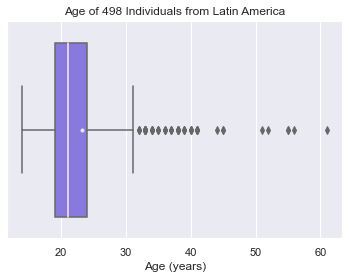

count    498.000000
mean      23.146586
std        6.721583
min       14.000000
25%       19.000000
50%       21.000000
75%       24.000000
max       61.000000
Name: Age, dtype: float64


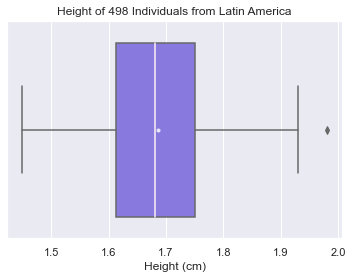

count    498.000000
mean       1.686386
std        0.097653
min        1.450000
25%        1.612500
50%        1.680000
75%        1.750000
max        1.980000
Name: Height, dtype: float64


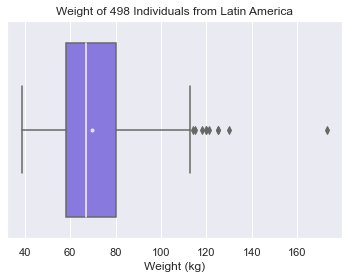

count    498.000000
mean      69.569880
std       17.013226
min       39.000000
25%       58.000000
50%       67.000000
75%       80.000000
max      173.000000
Name: Weight, dtype: float64


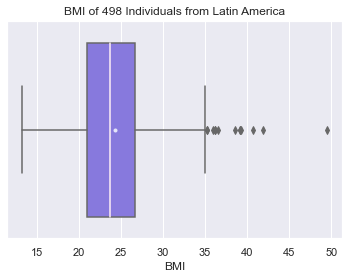

count    498.000000
mean      24.313544
std        4.772286
min       13.292000
25%       20.999000
50%       23.688500
75%       26.673000
max       49.472000
Name: BMI, dtype: float64


In [8]:
col1=['Age', 'Height', 'Weight', 'BMI']
for col in col1:
    sns.set(rc={'figure.figsize':(6,4)})
    b=sns.boxplot(x=col, data=df, showmeans=True, color='mediumslateblue', medianprops={'color':'lavenderblush'}, meanprops={'marker':'.','markerfacecolor':'lavender','markeredgecolor':'lavender'})
    if col=='Age':
        b.set(xlabel='Age (years)', title='Age of ' +str(len(df))+ ' Individuals from Latin America')
    elif col=='Height':
        b.set(xlabel='Height (cm)', title='Height of ' +str(len(df))+ ' Individuals from Latin America')
    elif col=='Weight':
        b.set(xlabel='Weight (kg)', title='Weight of ' +str(len(df))+ ' Individuals from Latin America')
    else:
        b.set(title='BMI of '+str(len(df))+' Individuals from Latin America')
    plt.show()
    print(df[col].describe())

In [9]:
df[df['Height']==df['Height'].max()]

,Gender,Age,Height,Weight,fam_hist,high_cal_foods,veg,num_main_meals,food_between_meals,nicotine,daily_water,cal_consumption_monitoring,physical_activity,time_using_tech_devices,alcohol,transportation,obesity_lvl,BMI
349,Male,20.0,1.98,125.0,yes,yes,2.0,3.0,Always,no,3.0,no,1.0,1.0,Sometimes,Public_Transportation,Obesity_Type_I,31.885


In [10]:
df[df['Weight']==df['Weight'].max()]

,Gender,Age,Height,Weight,fam_hist,high_cal_foods,veg,num_main_meals,food_between_meals,nicotine,daily_water,cal_consumption_monitoring,physical_activity,time_using_tech_devices,alcohol,transportation,obesity_lvl,BMI
344,Male,18.0,1.87,173.0,yes,yes,3.0,3.0,Frequently,no,2.0,no,2.0,1.0,Sometimes,Public_Transportation,Obesity_Type_III,49.472


There are no missing values. The age range is from 14 to 61, but the data seems to mostly consist of young adults of age 19 to 24, which is not very useful when observing obesity in young children or the elderly.

Height and weight are measured in cm and kg. We can observe a few outliers (max height = 198cm, max weight = 173kg), but it's not unrealistic. A histogram for the distribution of BMI based on obesity group is later shown.

We can also divide the metric Age values into quartiles so that Random Forest can later be used:

In [11]:
df['Age']

0      21.0
1      21.0
2      23.0
3      27.0
4      22.0
       ... 
493    20.0
494    18.0
495    19.0
496    18.0
497    20.0
Name: Age, Length: 498, dtype: float64

In [12]:
pd.qcut(df['Age'], q=4).unique()

[(19.0, 21.0], (21.0, 24.0], (24.0, 61.0], (13.999, 19.0]]
Categories (4, interval[float64, right]): [(13.999, 19.0] < (19.0, 21.0] < (21.0, 24.0] < (24.0, 61.0]]

In [13]:
df['age_group']=pd.qcut(df['Age'], q=4, labels=[0., 1., 2., 3.])

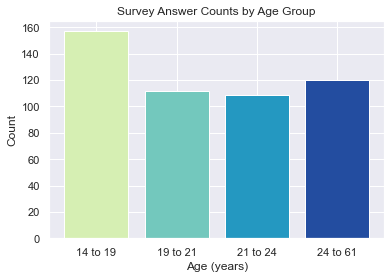

0.0    157
3.0    120
1.0    112
2.0    109
Name: age_group, dtype: int64


In [14]:
dict_age={0.: '14 to 19', 1.: '19 to 21', 2.: '21 to 24', 3.: '24 to 61'}
cmap=plt.get_cmap('YlGnBu')
bars=Counter(sorted(df['age_group']))
plt.bar(dict_age.values(), bars.values(), color=[cmap(i/5) for i in range(1,1+len(bars.values()),1)])
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.title('Survey Answer Counts by Age Group')
plt.show()
print(df['age_group'].value_counts())


This dataset was based on an internet survey and potentially targeted the younger population. It’s possible that this dataset is not an accurate representation of the whole population in Latin America.

In [15]:
df.head()

,Gender,Age,Height,Weight,fam_hist,high_cal_foods,veg,num_main_meals,food_between_meals,nicotine,daily_water,cal_consumption_monitoring,physical_activity,time_using_tech_devices,alcohol,transportation,obesity_lvl,BMI,age_group
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,24.387,1.0
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,24.238,1.0
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,23.765,2.0
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,26.852,3.0
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,28.342,2.0


## c) Ordinal Variables

**veg**, **num_main_meals**, **daily_water**, **physical_activity**, and **time_using_tech_devices** contain floats of ordinal values, some of which were interval values before conversion by the original authors of the dataset. These ordinal values correspond to levels of consumption or activity which was replaced in the graphs for easier visualization.

In [16]:
col2=['veg', 'num_main_meals', 'daily_water', 'physical_activity', \
      'time_using_tech_devices']
dicts_col2={'veg':{1.0:'Never', 2.0:'Sometimes', 3.0:'Always'}, \
       'num_main_meals':{1.0:'Between 1 and 2', 3.0:'3', 4.0:'More than 3'}, \
       'daily_water':{1.0:'Less than 1L', 2.0:'Between 1 and 2L', 3.0:'More than 2L'}, \
       'physical_activity':{0.0:'None', 1.0:'1 or 2 days', 2.0:'2 or 4 days', 3.0:'4 or 5 days'}, \
       'time_using_tech_devices':{0.0:'0 to 2 hours', 1.0:'3 to 5 hours', 2.0:'More than 5 hours'}}


2.0    272
3.0    194
1.0     32
Name: veg, dtype: int64


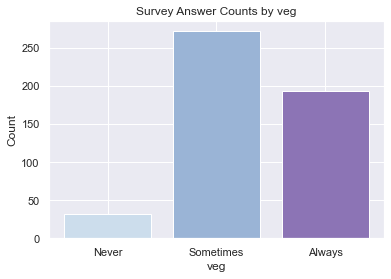

3.0    344
1.0    108
4.0     46
Name: num_main_meals, dtype: int64


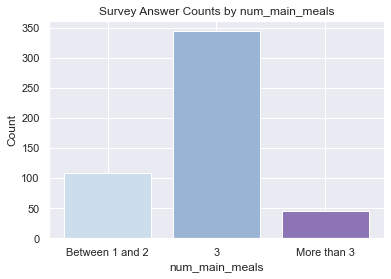

2.0    266
1.0    135
3.0     97
Name: daily_water, dtype: int64


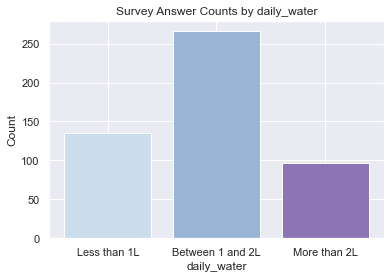

0.0    162
1.0    158
2.0    113
3.0     65
Name: physical_activity, dtype: int64


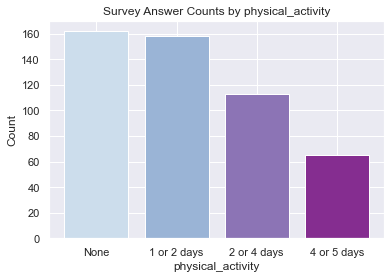

0.0    243
1.0    181
2.0     74
Name: time_using_tech_devices, dtype: int64


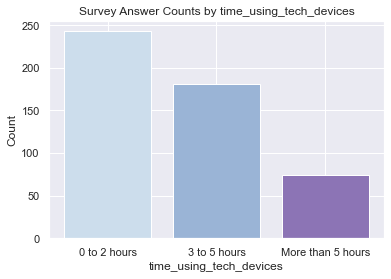

In [17]:
cmap=plt.get_cmap('BuPu')
for col in col2:
    bars=Counter(sorted(df[col]))
    plt.bar(dicts_col2[col].values(), bars.values(), \
            color=[cmap(i/5) \
                              for i in range(1,1+len(bars.values()),1)])
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title('Survey Answer Counts by '+str(col))
    print(df[col].value_counts())
    plt.show()

**food_between_meals** and **alcohol** contain ordinal survey answers which are not translated to numerical values.  

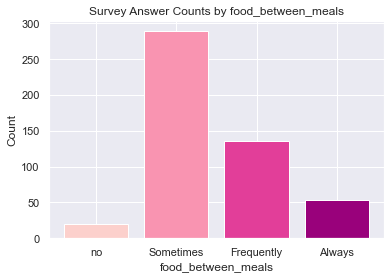

Sometimes     289
Frequently    136
Always         53
no             20
Name: food_between_meals, dtype: int64


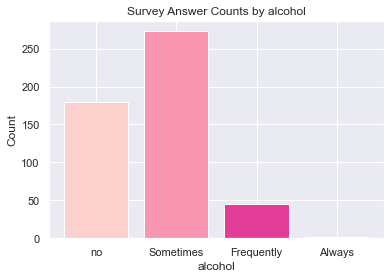

Sometimes     273
no            179
Frequently     45
Always          1
Name: alcohol, dtype: int64


In [18]:
cmap=plt.get_cmap('RdPu')
col3=['food_between_meals', 'alcohol']
for col in col3: 
    bars=Counter(sorted(df[col], reverse=True))
    plt.bar(bars.keys(), bars.values(), \
            color=[cmap(i/5) \
                              for i in range(1,1+len(bars.values()),1)])
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title('Survey Answer Counts by '+str(col))
    plt.show()
    print(df[col].value_counts())

Only one person responded 'Always' to alcohol consumption. We should remove this data and others with less than 20 value counts.

In [19]:
df[df['alcohol']=='Always']
df=df.drop(df[df['alcohol']=='Always'].index)

## d) Nominal Variables

**Gender**, **fam_hist**, **high_cal_foods**, **cal_consumption_monitoring**, **nicotine**, are dichotomous variables.

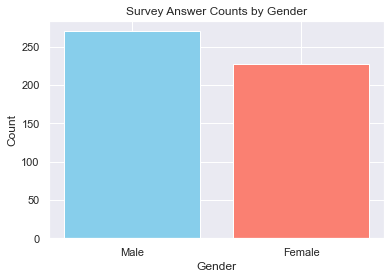

Male      270
Female    227
Name: Gender, dtype: int64


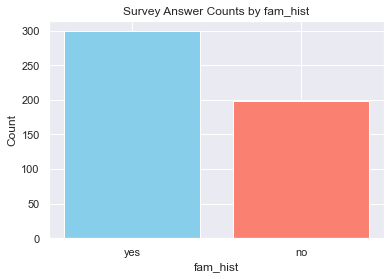

yes    299
no     198
Name: fam_hist, dtype: int64


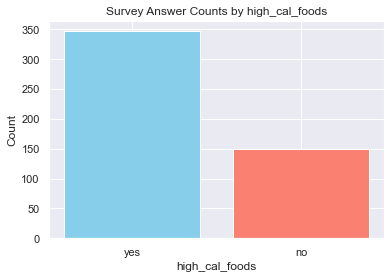

yes    347
no     150
Name: high_cal_foods, dtype: int64


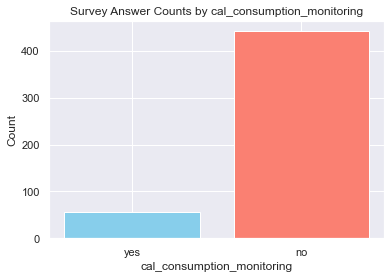

no     442
yes     55
Name: cal_consumption_monitoring, dtype: int64


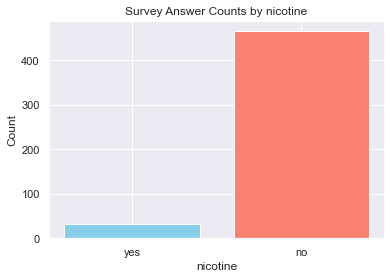

no     465
yes     32
Name: nicotine, dtype: int64


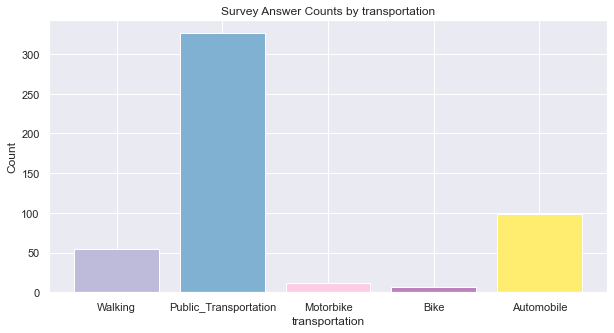

Public_Transportation    326
Automobile                99
Walking                   54
Motorbike                 11
Bike                       7
Name: transportation, dtype: int64


In [20]:
col4=['Gender', 'fam_hist', 'high_cal_foods', 'cal_consumption_monitoring', \
      'nicotine', 'transportation']
cmap=plt.get_cmap('Set3')
for col in col4: 
    bars=Counter(sorted(df[col], reverse=True))
    if col == 'transportation':
        plt.figure(figsize=(10,5))
        plt.bar(bars.keys(), bars.values(), \
               color=[cmap(i/5) \
                              for i in range(1,1+len(bars.values()),1)])
    else:
        plt.bar(bars.keys(), bars.values(), \
                color=['skyblue', 'salmon'])
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title('Survey Answer Counts by '+str(col))
    plt.show()
        
    print(df[col].value_counts())

In [21]:
#drop less than 20 value counts
df=df.drop(df[df['transportation']=='Motorbike'].index)
df=df.drop(df[df['transportation']=='Bike'].index)

There aren't many smokers and people who monitor calorie consumption compared to those who don't. There are more people who eat high calorie foods. 

The variable we want to compare, **obesity_lvl** is an ordinal variable which contain levels corresponding to the **BMI** as defined by the CDC. We can later choose the dependent variable to be qualitative (obesity level) or quantitative (BMI). 

## e) Distribution of BMI & Obesity Levels

Here we plot a histogram for all datapoints showing the BMI and obesity level range.

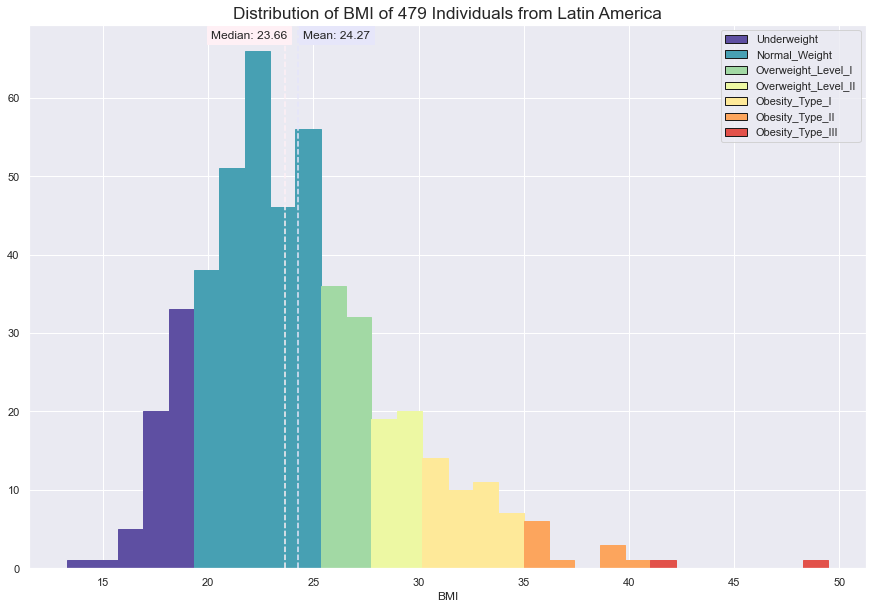

In [22]:
plt.figure(figsize=(15,10))
n, bins, patches=plt.hist(df.BMI,30)
bounds=[18.5,25.0,27.0,30.0,35.0,40.0]
cmap=plt.get_cmap('Spectral')

for bar in patches:
    x, y = bar.get_xy()
    w = bar.get_width()
    if x < bounds[0]:
        bar.set_color(cmap(1.0))
    elif x < bounds[1] and x >= bounds[0]:
        bar.set_color(cmap(6/7))
    elif x < bounds[2] and x >= bounds[1]:
        bar.set_color(cmap(5/7))
    elif x < bounds[3] and x >= bounds[2]:
        bar.set_color(cmap(4/7))
    elif x < bounds[4] and x >= bounds[3]:
        bar.set_color(cmap(3/7))
    elif x < bounds[5] and x >= bounds[4]:
        bar.set_color(cmap(2/7))
    elif x >= bounds[5]:
        bar.set_color(cmap(1/7))
        
handles=[matplotlib.patches.Rectangle((0,0),1,1,color=c,ec='k') for c in [cmap(i/7) for i in range(7,0,-1)]]
labels=[lvl for lvl in df.obesity_lvl.unique()]
labels.pop(4)
labels.insert(0, 'Underweight')
df.obesity_lvl=df.obesity_lvl.replace('Insufficient_Weight', 'Underweight')
plt.legend(handles,labels)
plt.xlabel('BMI')

min_ylim, max_ylim=plt.ylim()
plt.axvline(df.BMI.mean(), linestyle='dashed', color='lavender')
plt.text(df.BMI.mean()*1.01, max_ylim*0.975, 'Mean: '+str(round(df.BMI.mean(), 2)), fontsize='medium', backgroundcolor='lavender')

plt.axvline(df.BMI.median(), linestyle='dashed', color='lavenderblush')
plt.text(df.BMI.median()*0.85, max_ylim*0.975, 'Median: '+str(round(df.BMI.median(), 2)), fontsize='medium', backgroundcolor='lavenderblush')
plt.title('Distribution of BMI of '+str(len(df))+' Individuals from Latin America', fontsize='x-large')

plt.show()


The data seems to be right-skewed with the mean being larger than the median. The dataset may overrepresent the young population who have the least risk of obesity (source: https://www.wihealthatlas.org/obesity/age). There are also many categories of obesity levels but not many counts, especially for higher obesity. 


# 2. Bivariate Analysis

## a) Stacked Bar Charts & Parallel Boxplots

We can visualize group differences using frequency stacked barplots and boxplots.

In [23]:
#print min, max, counts for obesity levels

ob1=df[df.obesity_lvl=='Overweight_Level_I']
ob2=df[df.obesity_lvl=='Overweight_Level_II']
print([[df[df.obesity_lvl==lvl].min().BMI, df[df.obesity_lvl==lvl].max().BMI, \
        df[df.obesity_lvl==lvl].BMI.count(), lvl] for lvl in labels])


[[13.292, 18.424, 34, 'Underweight'], [18.491, 24.913, 276, 'Normal_Weight'], [25.076, 26.892, 55, 'Overweight_Level_I'], [26.99, 29.938, 57, 'Overweight_Level_II'], [30.11, 34.894, 44, 'Obesity_Type_I'], [35.003, 39.258, 10, 'Obesity_Type_II'], [40.645, 49.472, 3, 'Obesity_Type_III']]


Since we are trying to predict the general deflections away from normal weight, we can minimize the levels into four: underweight, normal weight, overweight, and obese.

In [24]:
dict_obesity={'Underweight':0., 'Normal_Weight':1., 'Overweight_Level_I':2., 'Overweight_Level_II':2., 'Obesity_Type_I':3., 'Obesity_Type_II':3., 'Obesity_Type_III':3.}
df['new_obesity_lvl']=df['obesity_lvl'].map(dict_obesity)


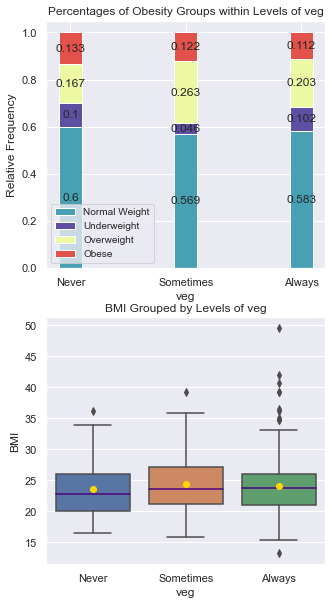

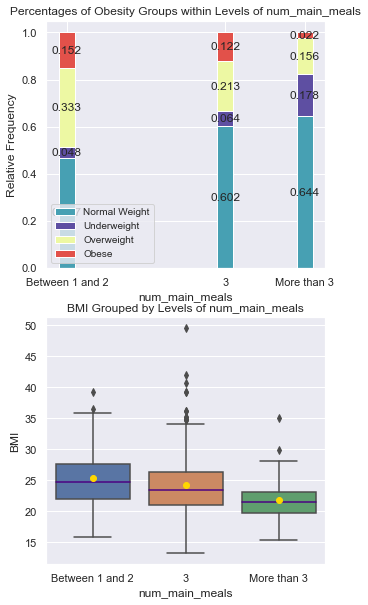

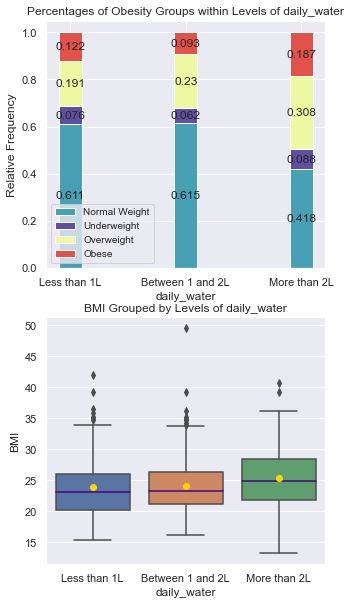

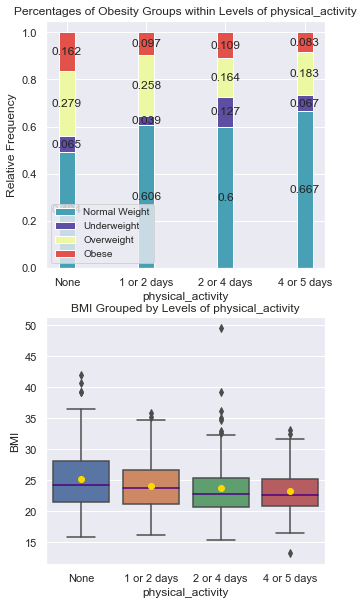

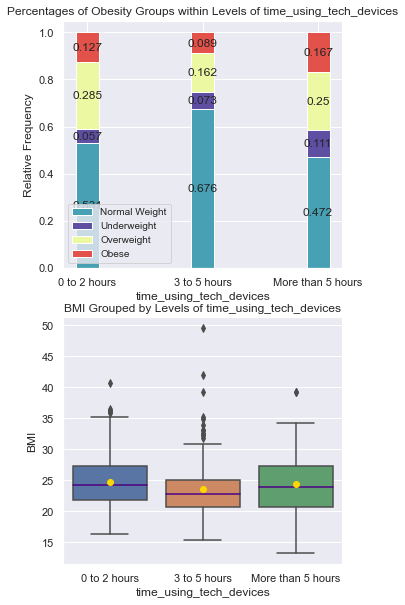

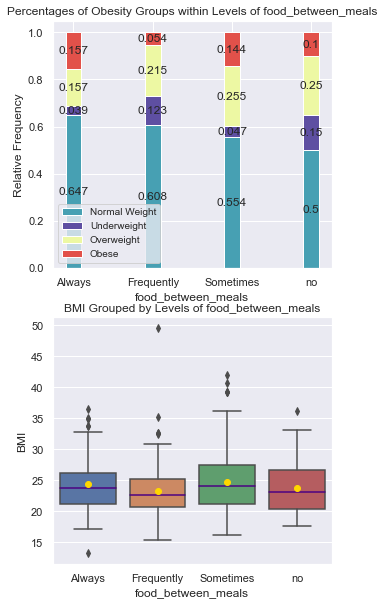

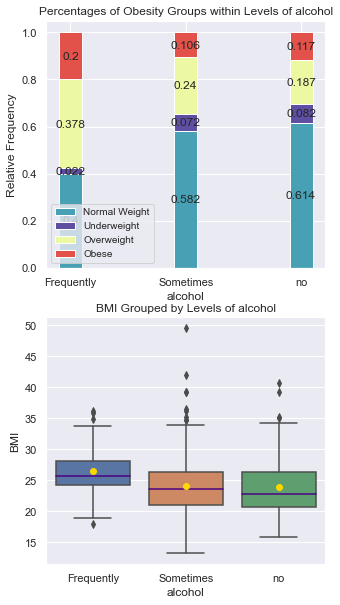

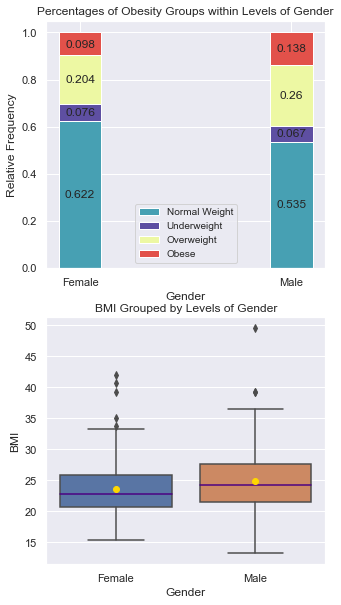

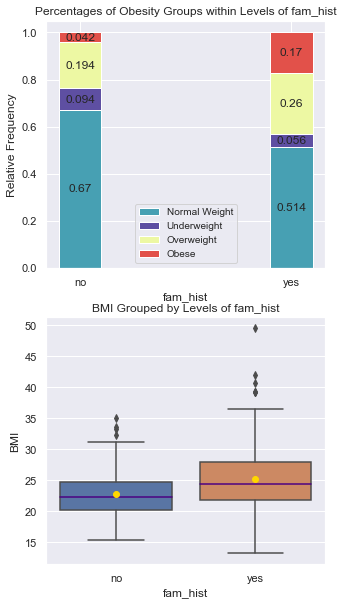

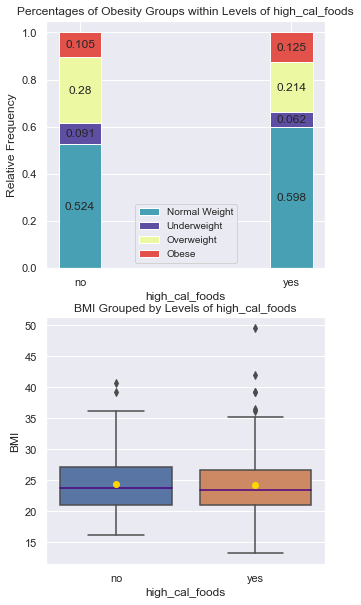

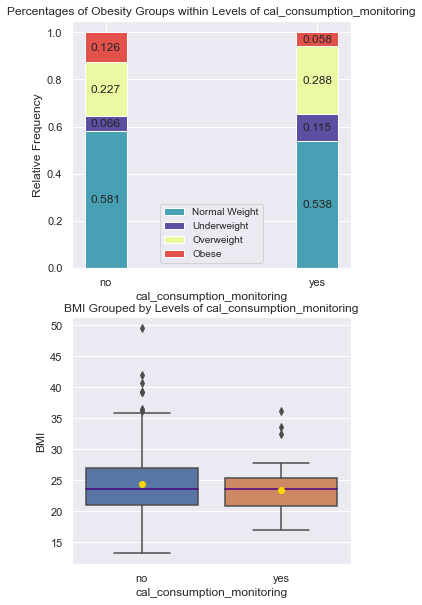

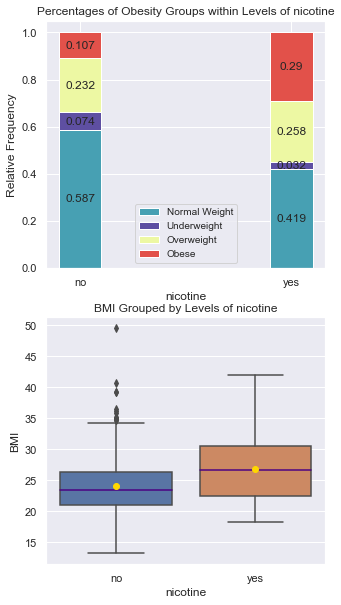

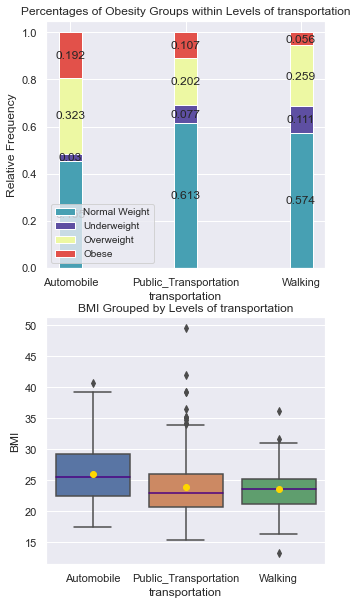

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


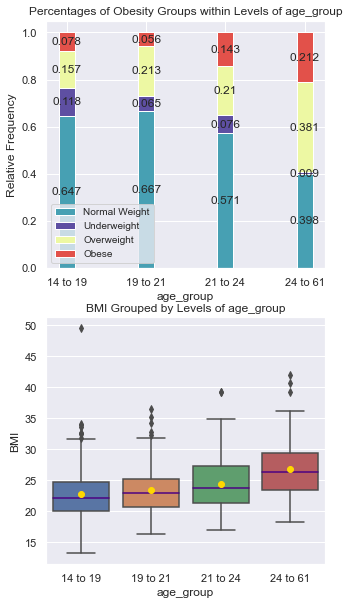

In [25]:
cols=col2+col3+col4+['age_group']

for col in cols:
    #calculate frequencies for each category
    categories=sorted(df[col].unique())
    underweight=[]
    normalweight=[]
    overweight=[]
    obese=[]
    for c in categories:
        c_con=df[col]==c
        n=len(df[c_con])
        underweight.append(len(df[(df['new_obesity_lvl']==0.) & (c_con)])/n)
        normalweight.append(len(df[(df['new_obesity_lvl']==1.) & (c_con)])/n)
        overweight.append(len(df[(df['new_obesity_lvl']==2.) & (c_con)])/n)
        obese.append(len(df[(df['new_obesity_lvl']==3.) & (c_con)])/n)

    underweight=np.array(underweight)
    normalweight=np.array(normalweight)
    overweight=np.array(overweight)
    obese=np.array(obese)
    
    #plot frequency barplots
    width=0.2
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,10))

    bar1=ax1.bar(categories, normalweight, label='Normal Weight', width=width, color=cmap(6/7))
    bar2=ax1.bar(categories, underweight, label='Underweight', bottom=normalweight, width=width, color=cmap(1.0))
    bar3=ax1.bar(categories, overweight, label='Overweight', bottom=normalweight+underweight, width=width, color=cmap(4/7))
    bar4=ax1.bar(categories, obese, label='Obese', bottom=overweight+normalweight+underweight, width=width, color=cmap(1/7))
    ax1.set_ylabel('Relative Frequency')
    ax1.set_xlabel(col)
    
    ax1.set_title('Percentages of Obesity Groups within Levels of ' + col)
    ax1.legend(fontsize=10)
    
    ax1.bar_label(bar1, labels=np.round(normalweight, 3), label_type='center')
    ax1.bar_label(bar2, labels=np.round(underweight, 3), label_type='center')
    ax1.bar_label(bar3, labels=np.round(overweight, 3), label_type='center')
    ax1.bar_label(bar4, labels=np.round(obese, 3), label_type='center')

    #plot boxplots
    ax2=sns.boxplot(x=col, y='BMI', data=df, showmeans=True, order=sorted(df[col].unique()), medianprops={'color':'indigo'}, meanprops={'marker':'o','markerfacecolor':'gold','markeredgecolor':'gold'})
    ax2.set_title('BMI Grouped by Levels of '+ col)
    if col == 'age_group':
        ax1.set_xticks(list(dict_age.keys()))
        ax1.set_xticklabels(dict_age.values())
        ax2.set_xticklabels(dict_age.values())
    elif col in dicts_col2.keys():
        ax1.set_xticks(list(dicts_col2[col].keys()))
        ax1.set_xticklabels(dicts_col2[col].values())
        ax2.set_xticklabels(dicts_col2[col].values())
    plt.show()

There are visible group mean differences and trends in **num_main_meals**, **daily_water**, **physical_activity**, **alcohol**, **Gender**, **fam_hist**, and **nicotine**.

H_0: There are no differences in group means.

H_A: There are differences in group means.

Higher vegetable consumption does not necessarily lead to less obesity but has a higher count of outliers. 

The higher the number of main meals, the lesser the weight, presumably due to that people who eat more frequently eat less portions. People who eat 3 meals per day have a lesser mean and median than those who eat lesser meals but are more spread out in terms of BMI. 

Those who consume more water are more obese and the distribution is wider.

Those who are more physically active tend to be less obese. 

People who use technological devices for 3 to 5 hours daily are least obese, but there are more outliers in this group. 

Having more food between meals doesn't seem to affect the mean and median much but also is attributed to more spread. 

Those who consume more nicotine or alcohol are more obese. 

Females have a lower percentage of obesity but a higher count of outliers.

People with no family history of obesity have less of a weight overall, regardless of what weight group they are in. 

Eating high caloric foods surprisingly does not correspond to more weight, perhaps due to the potential correlation of high caloric food consumption to physical activity.

People who use the car as their primary mode of transportation are most obese but ones who use public transportation have many outliers.

Monitoring caloric consumption does not seem to necessarily change the mean and median but decrease the spread. 


Overall, the means and medians don't seem to differ too much, but there seem to be differences within features which affect the overall distribution of BMI by pushing out the mean to the right. 

## b) Pooled T-test for Dichotomous Group Differences Means of BMI Scores

$H_0$: The difference in means of BMI scores between groups within the column is 0.

$H_A$: The difference in means of BMI scores between groups within the column is not 0.

In [26]:
dichotomous=['Gender', 'fam_hist', 'high_cal_foods', 'cal_consumption_monitoring', 'nicotine']

Gender: Female
 count    225.000000
mean      23.629893
std        4.445357
min       15.432000
25%       20.685000
50%       22.758000
75%       25.806000
max       41.913000
Name: BMI, dtype: float64 

 Gender: Male
 count    254.000000
mean      24.839988
std        4.949726
min       13.292000
25%       21.503500
50%       24.297500
75%       27.618750
max       49.472000
Name: BMI, dtype: float64 



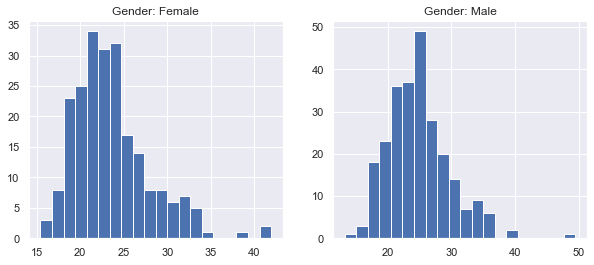

H_0: The difference in means of BMI scores between Gender groups is 0.
H_1: The difference in means of BMI scores between Gender groups is not 0.
Gender Ttest_indResult(statistic=-2.800628077605756, pvalue=0.005307433242157921)
We reject the null hypothesis. 

fam_hist: yes
 count    288.000000
mean      25.214972
std        5.171516
min       13.292000
25%       21.774000
50%       24.464000
75%       28.010750
max       49.472000
Name: BMI, dtype: float64 

 fam_hist: no
 count    191.000000
mean      22.849063
std        3.613683
min       15.432000
25%       20.236000
50%       22.313000
75%       24.746500
max       35.003000
Name: BMI, dtype: float64 



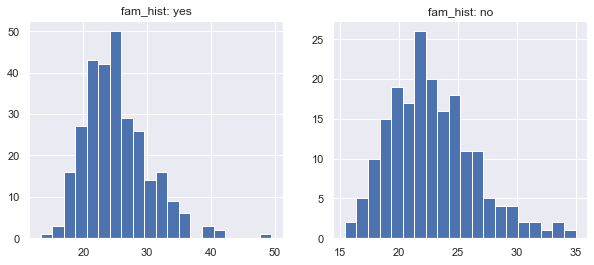

H_0: The difference in means of BMI scores between fam_hist groups is 0.
H_1: The difference in means of BMI scores between fam_hist groups is not 0.
fam_hist Ttest_indResult(statistic=5.494434196600998, pvalue=6.389675908049803e-08)
We reject the null hypothesis. 

high_cal_foods: no
 count    143.000000
mean      24.337427
std        4.722332
min       16.229000
25%       21.093500
50%       23.837000
75%       27.185000
max       40.645000
Name: BMI, dtype: float64 

 high_cal_foods: yes
 count    336.000000
mean      24.243545
std        4.773097
min       13.292000
25%       20.957000
50%       23.502500
75%       26.668500
max       49.472000
Name: BMI, dtype: float64 



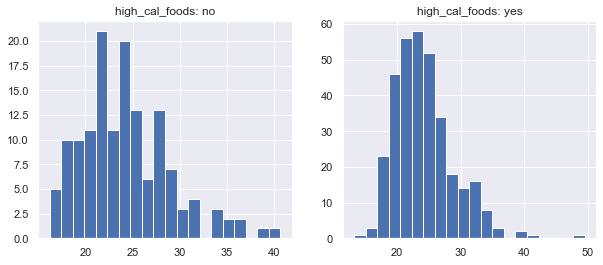

H_0: The difference in means of BMI scores between high_cal_foods groups is 0.
H_1: The difference in means of BMI scores between high_cal_foods groups is not 0.
high_cal_foods Ttest_indResult(statistic=0.19761674687092276, pvalue=0.8434291142883024)
We cannot reject the null hypothesis. 

cal_consumption_monitoring: no
 count    427.000000
mean      24.377028
std        4.836162
min       13.292000
25%       21.008000
50%       23.661000
75%       26.990000
max       49.472000
Name: BMI, dtype: float64 

 cal_consumption_monitoring: yes
 count    52.000000
mean     23.405615
std       3.941824
min      16.937000
25%      20.791000
50%      23.581000
75%      25.410500
max      36.157000
Name: BMI, dtype: float64 



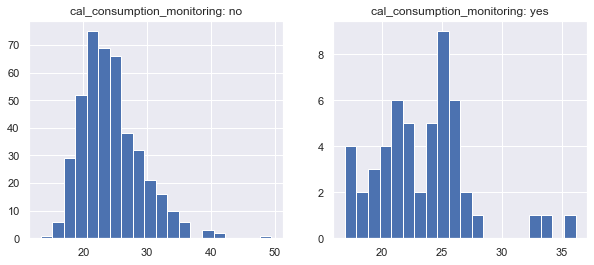

H_0: The difference in means of BMI scores between cal_consumption_monitoring groups is 0.
H_1: The difference in means of BMI scores between cal_consumption_monitoring groups is not 0.
cal_consumption_monitoring Ttest_indResult(statistic=1.392794371694379, pvalue=0.16433079093016767)
We cannot reject the null hypothesis. 

nicotine: no
 count    448.000000
mean      24.088897
std        4.616645
min       13.292000
25%       20.962250
50%       23.466000
75%       26.403000
max       49.472000
Name: BMI, dtype: float64 

 nicotine: yes
 count    31.000000
mean     26.911516
std       5.892290
min      18.218000
25%      22.541500
50%      26.667000
75%      30.465000
max      41.913000
Name: BMI, dtype: float64 



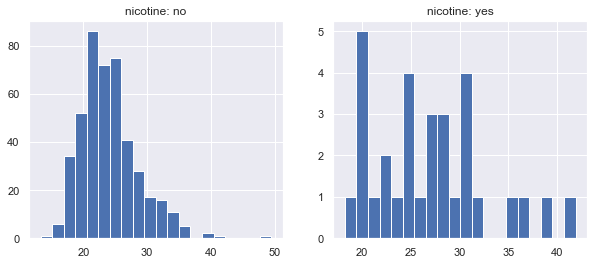

H_0: The difference in means of BMI scores between nicotine groups is 0.
H_1: The difference in means of BMI scores between nicotine groups is not 0.
nicotine Ttest_indResult(statistic=-3.228891294178137, pvalue=0.001328393288929754)
We reject the null hypothesis. 



In [27]:
alpha=0.05
for col in dichotomous:
    group1, group2 =df[col].unique()
    BMI1=df[df[col]==group1].BMI
    BMI2=df[df[col]==group2].BMI
    label1=col+': '+group1
    label2=col+': '+group2
    print(label1+'\n', BMI1.describe(),'\n\n', label2+'\n', BMI2.describe(),'\n')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.hist(BMI1, bins=20)
    ax2.hist(BMI2, bins=20)
    ax1.set_title(label1)
    ax2.set_title(label2)
    plt.show()
    ttest=ttest_ind(BMI1, BMI2)
    print('H_0: The difference in means of BMI scores between '+str(col)+' groups is 0.')
    print('H_1: The difference in means of BMI scores between '+str(col)+' groups is not 0.')
    print(col, ttest)
    if ttest[1]<alpha:
        print('We reject the null hypothesis. \n')
    else: 
        print('We cannot reject the null hypothesis. \n')

There is sufficient statistical evidence that there are differences in means of BMI scores between **gender**, **family history of obesity**, and **nicotine use** groups. Although the p-value for calorie consumption monitoring was also on the lower end (p-value=0.164),  we choose an alpha level of 0.05 so it is not statistically significant. 

## c) Chi-Squares for Categorical Variables with Multiple Levels

In [28]:
multiplelvls=col2+col3+['transportation', 'age_group']
print(multiplelvls)

['veg', 'num_main_meals', 'daily_water', 'physical_activity', 'time_using_tech_devices', 'food_between_meals', 'alcohol', 'transportation', 'age_group']


In [29]:
dict_obese={0.0: 'no', 1.0: 'no', 2.0: 'yes', 3.0: 'yes'}
df['obese']=df['new_obesity_lvl'].map(dict_obese)
df.head()

,Gender,Age,Height,Weight,fam_hist,high_cal_foods,veg,num_main_meals,food_between_meals,nicotine,...,cal_consumption_monitoring,physical_activity,time_using_tech_devices,alcohol,transportation,obesity_lvl,BMI,age_group,new_obesity_lvl,obese
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,...,no,0.0,1.0,no,Public_Transportation,Normal_Weight,24.387,1.0,1.0,no
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,...,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,24.238,1.0,1.0,no
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,...,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,23.765,2.0,1.0,no
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,...,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,26.852,3.0,2.0,yes
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,...,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,28.342,2.0,2.0,yes


In [30]:
for col in multiplelvls:
    table=pd.crosstab(df[col], df['obese'])
    print(table.to_markdown())
    Xsq=stats.chi2_contingency(table)
    print('H_0: There is no relationship between '+str(col)+' and obesity.')
    print('H_1: There is a relationship between '+str(col)+' and obesity.')
    print('Chi-square value:', Xsq[0], 'p-value:', Xsq[1], 'dof:', Xsq[2],'\n', 'Expected Frequencies: \n', tabulate(Xsq[3]))
    if Xsq[1]<alpha:
        print('We reject the null hypothesis. \n')
    else: 
        print('We cannot reject the null hypothesis. \n')

|   veg |   no |   yes |
|------:|-----:|------:|
|     1 |   21 |     9 |
|     2 |  161 |   101 |
|     3 |  128 |    59 |
H_0: There is no relationship between veg and obesity.
H_1: There is a relationship between veg and obesity.
Chi-square value: 2.731845525560849 p-value: 0.25514512889919344 dof: 2 
 Expected Frequencies: 
 --------  -------
 19.4154  10.5846
169.562   92.4384
121.023   65.977
--------  -------
We cannot reject the null hypothesis. 

|   num_main_meals |   no |   yes |
|-----------------:|-----:|------:|
|                1 |   54 |    51 |
|                3 |  219 |   110 |
|                4 |   37 |     8 |
H_0: There is no relationship between num_main_meals and obesity.
H_1: There is a relationship between num_main_meals and obesity.
Chi-square value: 14.651384434629247 p-value: 0.0006584037471538861 dof: 2 
 Expected Frequencies: 
 --------  --------
 67.9541   37.0459
212.923   116.077
 29.1232   15.8768
--------  --------
We reject the null hypothesis. 



There is sufficient statistical evidence that there is a relationship between being overweight (BMI > 25) and each of **number of main meals**, **daily water consumption**, **physical activity**, **time using technological devices**, **alcohol**, **transportation**, and **age** at a 95% confidence level. It should be noted that **food between meals** had a p-value of 0.07, very close to alpha=0.05.

# 3. Multivariate Analysis

We can visualize the correlation between columns using the Pearson's correlation coefficient. First we convert the ordinal categories into numerical levels:

In [31]:
dict_col3={'no': 0., 'Sometimes': 1., 'Frequently': 2., 'Always': 3.}
for col in col3:
    df[col]=df[col].map(dict_col3)
df.head()

,Gender,Age,Height,Weight,fam_hist,high_cal_foods,veg,num_main_meals,food_between_meals,nicotine,...,cal_consumption_monitoring,physical_activity,time_using_tech_devices,alcohol,transportation,obesity_lvl,BMI,age_group,new_obesity_lvl,obese
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,1.0,no,...,no,0.0,1.0,0.0,Public_Transportation,Normal_Weight,24.387,1.0,1.0,no
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,1.0,yes,...,yes,3.0,0.0,1.0,Public_Transportation,Normal_Weight,24.238,1.0,1.0,no
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,1.0,no,...,no,2.0,1.0,2.0,Public_Transportation,Normal_Weight,23.765,2.0,1.0,no
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,1.0,no,...,no,2.0,0.0,2.0,Walking,Overweight_Level_I,26.852,3.0,2.0,yes
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,1.0,no,...,no,0.0,0.0,1.0,Public_Transportation,Overweight_Level_II,28.342,2.0,2.0,yes


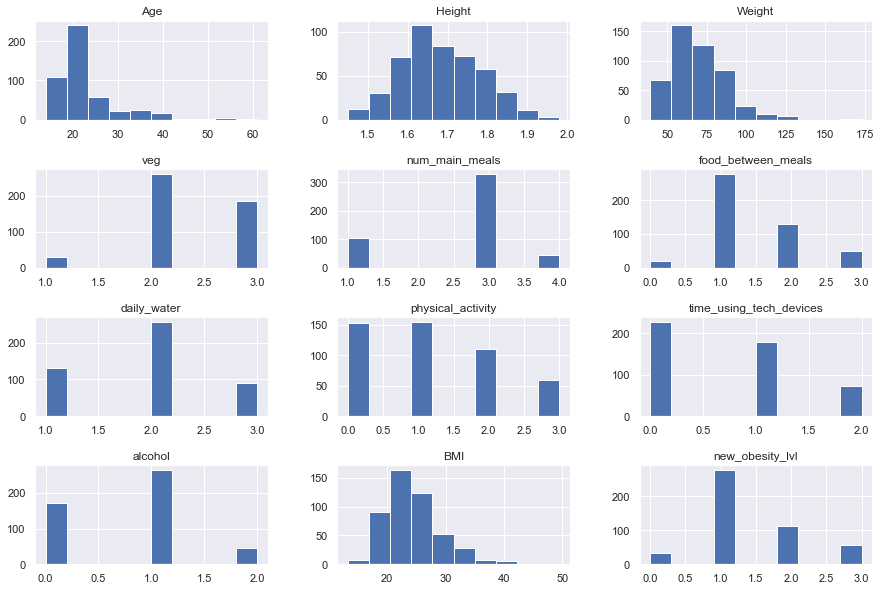

In [32]:
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

## a) Pearson's Correlation Heatmap

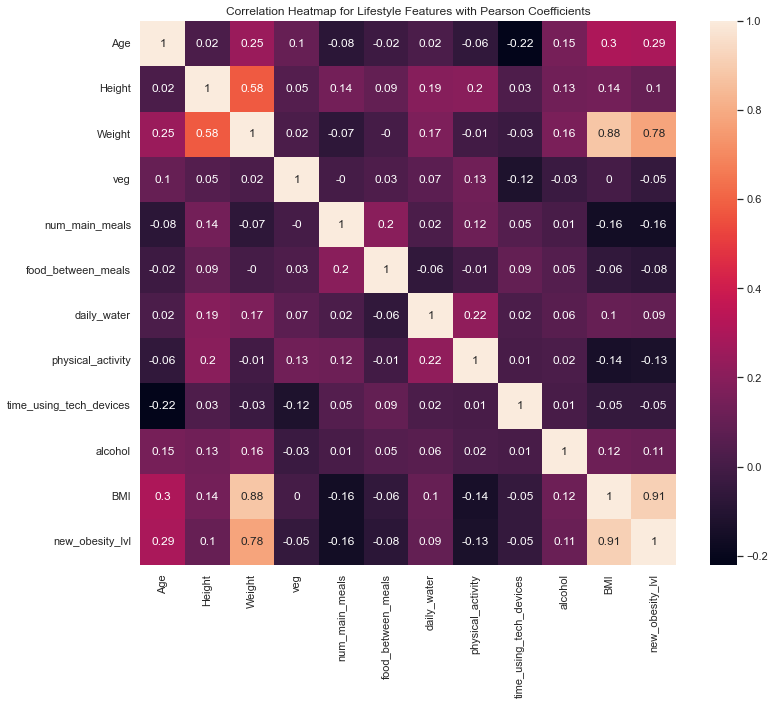

In [33]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(round(df.corr(), 2), annot=True)
ax.set_title('Correlation Heatmap for Lifestyle Features with Pearson Coefficients');


**BMI** and **weight** are highly correlated (r=0.88), as BMI is a function of weight. **Height** and **weight** are obviously highly correlated (r=0.58). BMI is also a function of height but is less dependent on height than weight with only a Pearson coefficient of 0.14. **Age** and **BMI** are only moderately correlated (r=0.3).



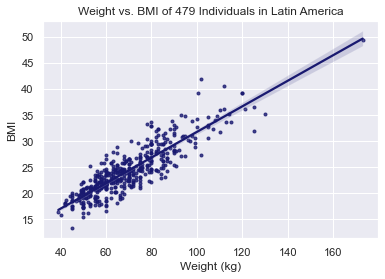

In [34]:
wb=sns.regplot(x='Weight', y='BMI', data=df, marker='.', color='midnightblue')
wb.set_xlabel('Weight (kg)')
wb.set_title('Weight vs. BMI of '+ str(len(df)) + ' Individuals in Latin America');

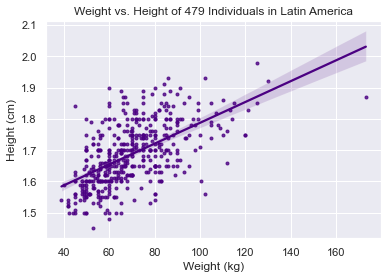

In [35]:
wh=sns.regplot(x='Weight', y='Height', data=df, marker='.', color='indigo')
wh.set_xlabel('Weight (kg)')
wh.set_ylabel('Height (cm)')
wh.set_title('Weight vs. Height of '+ str(len(df)) + ' Individuals in Latin America');

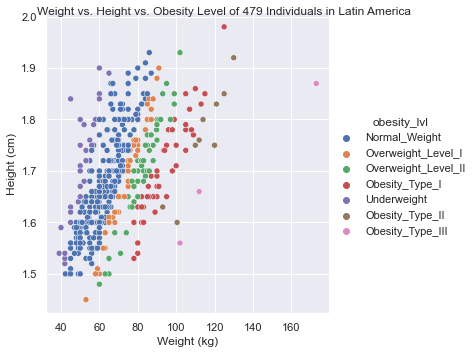

In [36]:
hwo=sns.relplot(x='Weight', y='Height', hue='obesity_lvl', data=df)
hwo.set_axis_labels('Weight (kg)', 'Height (cm)')
hwo.fig.suptitle('Weight vs. Height vs. Obesity Level of '+ str(len(df)) + ' Individuals in Latin America', fontsize=12);

Other slight correlations (r~0.2):
- Age and weight (r=0.25)
- Age and time_using_tech_devices (r=-0.22)
- Height and daily_water (r=0.19)
- Height and physical_activity (r=0.2)
- daily_water and physical_activity (r=0.22)
- num_main_meals and food_between_meals (r=0.2)

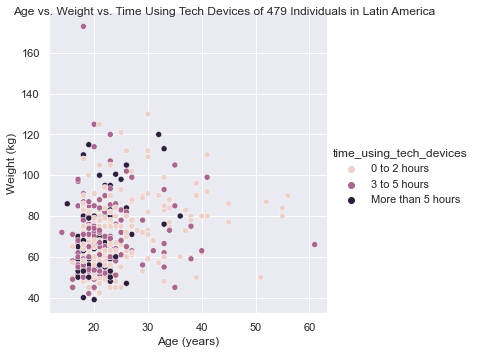

In [37]:
awt=sns.relplot(x='Age', y='Weight', hue='time_using_tech_devices', data=df)
awt.set_axis_labels('Age (years)', 'Weight (kg)')
awt.fig.suptitle('Age vs. Weight vs. Time Using Tech Devices of '+ str(len(df)) + ' Individuals in Latin America', fontsize=12)
for i in range(3):
    awt._legend.texts[i].set_text(dicts_col2['time_using_tech_devices'][float(i)])

Physical activity, height, and daily water intake have a three-way positive correlation (physical activity & height: r=0.2, daily water intake & height: r=0.19, physical activity & daily water intake: r=0.22), which is reflective of that taller people may be more prone to partake in sport activities due to better spatial awareness (source: https://www.science.org/doi/10.1126/sciadv.1501070). Additionally, daily water intake is larger in taller people, which may be mostly explained by physical activity since the correlations are similar in value. 


Number of main meals is positively correlated with food between meals, meaning the two represent the frequency of how much people eat. However, frequency has no correlation with weight itself, and number of main meals has a slight negative correlation with BMI (r=-0.16).


**It is important to note that these correlations are too miniscule to affect the outcome. The features with the highest correlations, weight and height, are directly related to BMI by definition, so it's counter intuitive to include them in our analysis.** There seems to be no other correlations that stand out, but we should also consider the categorical variables which are not shown in the heatmap. 


## b) Cramer's V Heatmap

We can create a new heatmap showing the categorical 
variables and appropriately calculate the Cramer's V.

In [38]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [39]:
rows=[]
cols+=['obesity_lvl']
for c1 in cols:
    col=[]
    for c2 in cols:
        cramers=cramers_v(df[c1], df[c2])
        col.append(round(cramers,2))
    rows.append(col)
    
cramersV_df=pd.DataFrame(np.array(rows), columns=cols, index=cols)


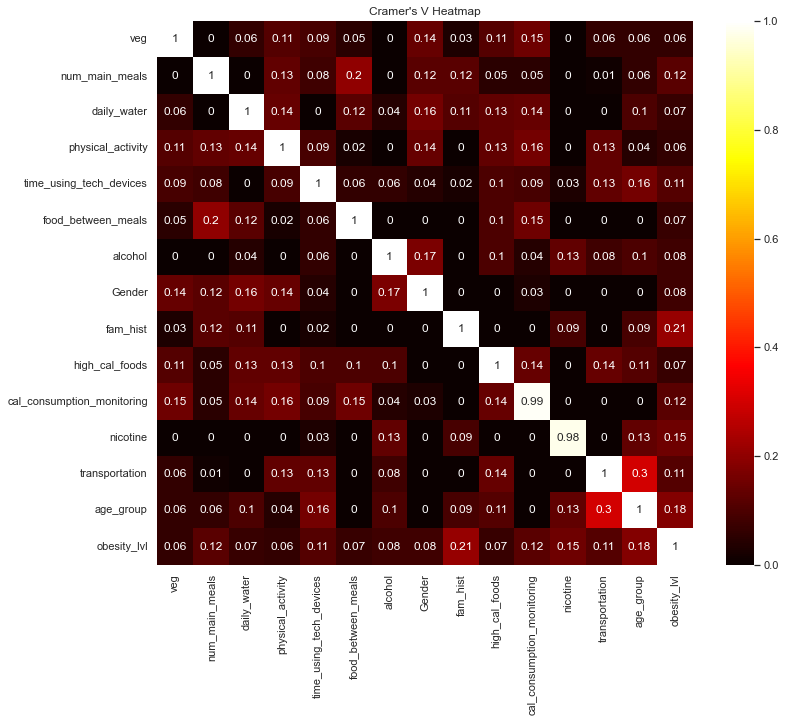

In [40]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cramersV_df[cols], annot=True, cmap='hot')
ax.set_title("Cramer's V Heatmap");

Cramer's V doesn't show much correlation between the categorical variables except age_group and transportation (r=0.36), fam_hist and obesity_lvl (r=0.21), and num_main_meals and food_between_meals (r=0.2). Again, they are very slight correlations.

**We conclude that no features have so much similarity that they should be excluded.** 


## c) Feature Importances

In [41]:
for col in set(col4)-set(['Gender', 'transportation']):
    df[col]=df[col].map({'no':0., 'yes':1.})

df['Gender']=df['Gender'].map({'Female':0., 'Male':1.})
df['transportation']=df['transportation'].map({'Automobile':0., 'Public_Transportation':1., 'Walking':2.})


In [42]:
def forest(indep, dep, kind='built-in'):
    X=df[indep]
    y=df[[dep]]
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=16)
    rf=RandomForestRegressor(n_estimators=100)
    rf.fit(X_train, y_train.values.ravel())
    if kind=='built-in':
        i=rf.feature_importances_.argsort()
        plt.barh(np.array(indep)[i], rf.feature_importances_[i])
        plt.title('Random Forest Built-in Feature Importances')
    elif kind=='perm':
        perm_importance=permutation_importance(rf, X_test, y_test)
        i=perm_importance.importances_mean.argsort()
        plt.barh(np.array(indep)[i], perm_importance.importances_mean[i])
        plt.title('Permutation Based Feature Importances')
    elif kind=='shap':
        explainer=shap.TreeExplainer(rf)
        shap_values=explainer.shap_values(X_test)
        plt.figure(figsize=(10,8))
        shap.summary_plot(shap_values, X_test, plot_type='bar', color='royalblue', plot_size=None, show=False)
        shap.summary_plot(shap_values, X_test, plot_size=None, show=False, alpha=0.3)
        
        plt.show()

Because BMI is a function of weight and height by definition, we can exclude them.

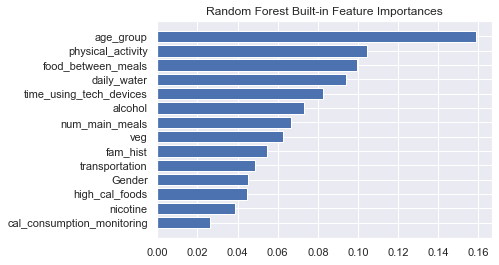

In [43]:
cols=['age_group']+col2+col3+col4
forest(indep=cols, dep='new_obesity_lvl') 

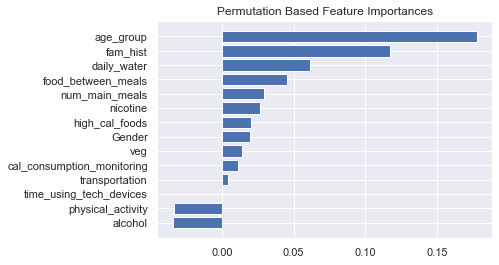

In [44]:
forest(indep=cols, dep='new_obesity_lvl', kind='perm')

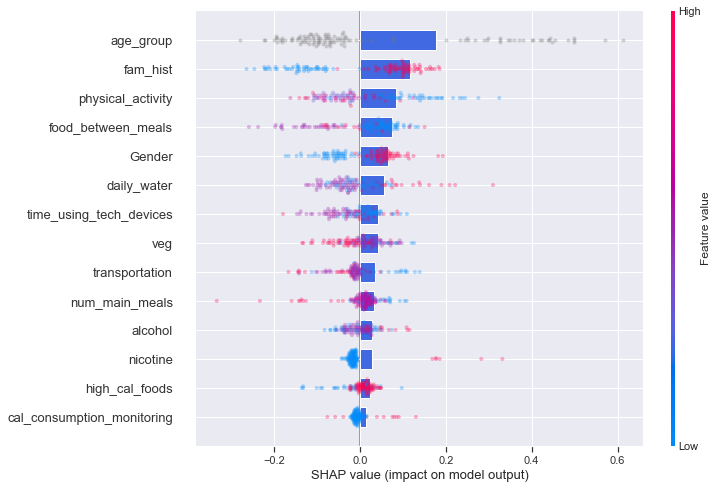

In [45]:
forest(indep=cols, dep='new_obesity_lvl', kind='shap')

The age group seems to have the biggest influence on obesity regardless of the type of feature importance test. **From all the feature importances analyses, the age group, family history, physical activity, daily water intake, and food between meals were found to be the most consistent top 5 features.**
